In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import sympy as smp

## Propeller data

In [15]:
D = 12 * 25.4 / 1000 # diameter in meters
rho = 1.225 # air density
Va = 18 # horizontal flight velocity
DS = np.loadtxt('Static.txt', dtype=float, skiprows=1)
Oms = DS[:, 0]
cts = DS[:, 1]
cqs = DS[:, 2] / (2 * np.pi)
pcqs = np.polyfit(Oms, cqs, 2)

D3 = np.loadtxt('3000RPM.txt', dtype=float, skiprows=1)
J3 = D3[:, 0]
ct3 = D3[:, 1]
cq3 = D3[:, 2] / (2 * np.pi)
eta3 = D3[:, 3]

D4 = np.loadtxt('4000RPM.txt', dtype=float, skiprows=1)
J4 = D4[:, 0]
ct4 = D4[:, 1]
cq4 = D4[:, 2] / (2 * np.pi)
eta4 = D4[:, 3]

D5 = np.loadtxt('5000RPM.txt', dtype=float, skiprows=1)
J5 = D5[:, 0]
ct5 = D5[:, 1]
cq5 = D5[:, 2] / (2 * np.pi)
eta5 = D5[:, 3]

D6 = np.loadtxt('6000RPM.txt', dtype=float, skiprows=1)
J6 = D6[:, 0]
ct6 = D6[:, 1]
cq6 = D6[:, 2] / (2 * np.pi)
eta6 = D6[:, 3]

Ct = np.concatenate((ct3, ct4), axis=0)
Ct = np.concatenate((Ct, ct5), axis=0)
Ct = np.concatenate((Ct, ct6), axis=0)

Cq = np.concatenate((cq3, cq4), axis=0)
Cq = np.concatenate((Cq, cq5), axis=0)
Cq = np.concatenate((Cq, cq6), axis=0)

J = np.concatenate((J3, J4), axis=0)
J = np.concatenate((J, J5), axis=0)
J = np.concatenate((J, J6), axis=0)

eta = np.concatenate((eta3, eta4), axis=0)
eta = np.concatenate((eta, eta5), axis=0)
eta = np.concatenate((eta, eta6), axis=0)

## Motor Data

In [16]:
MD = np.loadtxt('D:/Education/SKAT2025/KB-102_SKAT_2025/СиловаяУстановка/X2814.txt', dtype= float, skiprows=1)
i0 = float(MD[0, 2])
R = float(MD[0, 1])
kv = MD[0,0] # RPM/volts
kv = float(2*np.pi * kv /60 ) # Volts/(rad/sec)
kq = float(1/kv)
kv = kv**-1
MD, kv

(array([[9.00e+02, 3.36e-02, 1.20e+00, 1.08e-01],
        [1.00e+03, 3.55e-02, 1.30e+00, 1.13e-01],
        [1.20e+03, 2.13e-02, 1.70e+00, 1.10e-01]]),
 0.01061032953945969)

## Functions

In [17]:
pcq = np.polyfit(J, Cq, 2)
pcq3 = np.polyfit(J3, cq3, 2)
pcq4 = np.polyfit(J4, cq4, 2)
pcq5 = np.polyfit(J5, cq5, 2)
pcq6 = np.polyfit(J6, cq6, 2)
pct = np.polyfit(J, Ct, 2)
pct3 = np.polyfit(J3, ct3, 2)
pct4 = np.polyfit(J4, ct4, 2)
pct5 = np.polyfit(J5, ct5, 2)
pct6 = np.polyfit(J6, ct6, 2)
peta = np.polyfit(J, eta, 2)

def GetAR(Om, V):
    om = Om * 2 * np.pi / 60
    return 2*np.pi*V/(om * D)

def GetOmega(AR, V): 
    return (2 * np.pi * V / (D * AR)) / (2 * np.pi) * 60

def GetMTorque(Om, Vin):
    om = Om * 2 * np.pi / 60
    return kv*((Vin - kv*om)/R - i0)

def GetTorque(Om, V):
    om = Om * 2 * np.pi / 60
    r = om
    for i in range(np.size(Om)):
        if Om[i] < 3500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq3, GetAR(Om[i], V)) / (4 * np.pi**2)
        elif Om[i] < 4500 and Om[i] >= 3500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq4, GetAR(Om[i], V)) / (4 * np.pi**2)
        elif Om[i] < 5500 and Om[i] >= 4500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq5, GetAR(Om[i], V)) / (4 * np.pi**2)
        elif Om[i] >= 5500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq6, GetAR(Om[i], V)) / (4 * np.pi**2)
    return r

def GetThrust(Om, V):
    om = Om * 2 * np.pi / 60
    r = om
    for i in range(np.size(Om)):
        if Om[i] < 3500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct3, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] < 4500 and Om[i] >= 3500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct4, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] < 5500 and Om[i] >= 4500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct5, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] >= 5500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct6, GetAR(Om[i], V)) / (4 * np.pi**2)
    return r

def GetCurrent(Om, Vin):
    om = Om * 2 * np.pi / 60
    return (Vin - om*kv)/R

def GetPower(Om, V):
    om = Om * 2 * np.pi / 60
    return GetTorque(Om, V) * om

def GetMEff(Om, Vin):
    om = Om * 2 * np.pi / 60
    i = (Vin - kv*om)/R
    return (1 - i0/i)*kq/(kv*(1 + i*R/(kv*om))) 

def GetMPower(Vin, Om):
    om  = Om * 2 * np.pi / 60
    return Vin * (Vin - kv*om)/R

def GetVoltage(Om, Va):
    v = smp.symbols('v', real=True, positive=True)
    Qp = GetTorque(Om, Va)
    Qm = GetMTorque(Om, v)
    return smp.solve(Qm-Qp, v)[v]

def GetRPM(Va, target):
    Omega = np.linspace(2500, 10000, 10000)
    for el in Omega:
        Th = GetThrust(np.array([el]), Va)
        if abs(Th - target) <= 0.01:
            return el

(0.0, 1.0)

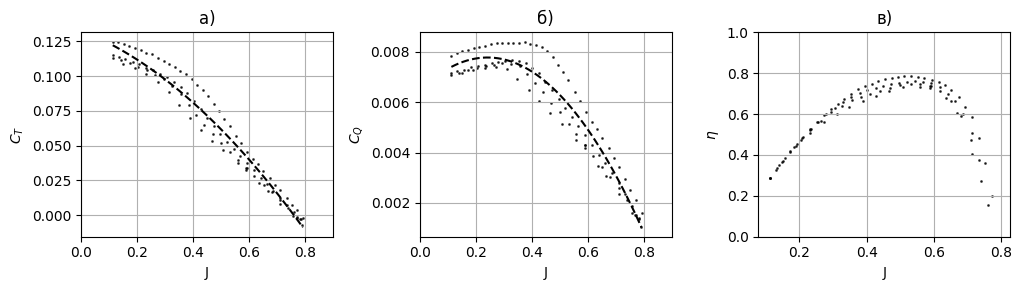

In [18]:
fig1, ax1 = plt.subplots(1,3, figsize=(87.4*3/25.4, 3))
fig1.set_layout_engine('tight')
ax1 = ax1.ravel()
ax1[0].scatter(J, Ct, s=1, c='black', alpha=0.7)
ax1[0].plot(np.linspace(np.min(J), np.max(J)), np.polyval(pct, np.linspace(np.min(J), np.max(J))), '--', c='black')
ax1[0].set_xlabel('J')
ax1[0].set_ylabel(r'$C_T$')
ax1[0].grid('Major')
ax1[0].set_title('a)')
ax1[1].set_title('б)')

ax1[0].set_xlim(0, 0.9)
ax1[1].scatter(J, Cq, s=1, c='black', alpha=0.7)
ax1[1].plot(np.linspace(np.min(J), np.max(J)), np.polyval(pcq, np.linspace(np.min(J), np.max(J))), '--', c='black')
ax1[1].set_xlabel('J')
ax1[1].set_ylabel(r'$C_Q$')
ax1[1].grid('Major')
ax1[1].set_xlim(0, 0.9)

ax1[2].scatter(J, eta, s=1, c='black', alpha=0.7)
# ax1[2].plot(np.linspace(np.min(J), np.max(J)), np.polyval(peta, np.linspace(np.min(J), np.max(J))), '--', c='black')
ax1[2].set_xlabel('J')
ax1[2].set_ylabel(r'$\eta$')
ax1[2].grid('Major')
ax1[2].set_title('в)')
ax1[2].set_ylim(0, 1)

(array([12.99247951]),
 np.float64(6046.354635463546),
 np.float64(0.2704522923266048),
 np.float64(203.23915358090295),
 np.float64(0.8425690911674149))

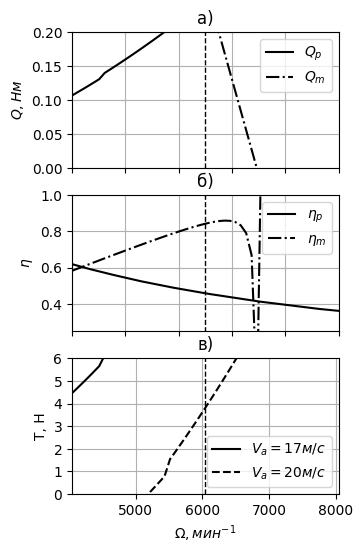

In [22]:
fig2, ax2 = plt.subplots(3,1, figsize=(87.4 /25.4, 6))
ax2.ravel()

Va = 6
RPM = GetRPM(Va, 13)
Vin = float(GetVoltage(np.array([RPM]), Va))

ax2[0].plot(np.linspace(RPM-2000, RPM+2000), GetTorque(np.linspace(RPM-2000, RPM+2000), Va), label = r'$Q_{p}$', color='black')
ax2[0].plot(np.linspace(RPM-2000, RPM+2000), GetMTorque(np.linspace(RPM-2000, RPM+2000), Vin), '-.',label = r'$Q_{m}$', color='black')
ax2[0].vlines(RPM, 0, 1, linestyle='--', color='black', linewidth=1)
ax2[0].set_ylim(0, 0.2)
ax2[0].set_ylabel(r'$Q, Нм$')
ax2[0].set_xticks(ticks = np.linspace(RPM-2000, RPM+2000, 6), labels = [' ', ' ', ' ', ' ', ' ', ' '], color='w')
ax2[0].set_xlim(RPM-2000, RPM+2000)
ax2[0].grid('Major')
ax2[0].legend()
ax2[0].set_title('a)')

ax2[1].plot(GetOmega(J6, Va), eta6, label = r'$\eta_{p}$', color='black')
ax2[1].vlines(RPM, 0, 1, linestyle='--', color='black', linewidth=1)
ax2[1].plot(np.linspace(RPM-2000, RPM+2000), GetMEff(np.linspace(RPM-2000, RPM+2000), Vin), '-.',label = r'$\eta_{m}$', color='black')
ax2[1].set_ylim(0.25, 1)
ax2[1].set_xlim(RPM-2000, RPM+2000)
ax2[1].set_ylabel(r'$\eta$')
ax2[1].set_xticks(ticks = np.linspace(RPM-2000, RPM+2000, 6), labels = [' ', ' ', ' ', ' ', ' ', ' '], color='w')
ax2[1].grid('Major')
ax2[1].legend()
ax2[1].set_title('б)')

ax2[2].plot(np.linspace(RPM-2000, RPM+2000), GetThrust(np.linspace(RPM-2000, RPM+2000), Va), color='black', label=r'$V_a = 17 м/с$')
ax2[2].plot(np.linspace(RPM-2000, RPM+2000), GetThrust(np.linspace(RPM-2000, RPM+2000), 20), '--', color='black', label=r'$V_a = 20 м/с$')
ax2[2].vlines(RPM, 0, 10, linestyle='--', color='black', linewidth=1)
ax2[2].set_ylim(0, 6)
ax2[2].set_xlim(RPM-2000, RPM+2000)
ax2[2].set_ylabel('T, Н')
ax2[2].set_yticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = ['0', '1','2','3','4','5','6'])
ax2[2].grid('Major')
ax2[2].set_xlabel(r'$\Omega, мин^{-1}$')
ax2[2].set_title('в)')
ax2[2].legend()
# plt.savefig('MotorMatching.png', dpi=300, bbox_inches='tight', pad_inches = 0)
GetThrust(np.array([RPM]), Va), RPM, GetMTorque(RPM, Vin), GetMPower(Vin, RPM), GetMEff(RPM, Vin)